In [100]:
import warnings
warnings.filterwarnings('ignore')

In [101]:
import numpy as np
import tensorflow as tf
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import mean_squared_error

In [70]:
# Load the dataset
player_stats = pd.read_csv("Data/cleaned_NBA_stats.csv")

In [71]:
# Define predictors
predictors = ["Age", "G", "GS", "MP", "FG", "FGA", 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 
              'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'W', 'L', 'W/L%', 'GB', 'PS/G', 'PA/G', 'SRS']

In [72]:
# Filter data based on the given conditions
player_stats_filtered = player_stats[((player_stats['G']>48)&(player_stats['PTS']>13.5)&(player_stats['MP']>30)
                                      &(player_stats['AST']>1)&(player_stats['TRB']>3)
                                      &(player_stats['FG%']>0.37)&(player_stats['FGA']>10)
                                      &(player_stats['Share']>0))]

In [73]:
# Splitting the data into training and testing sets
train = player_stats_filtered[~(player_stats_filtered["Year"] == 2022)]
test = player_stats_filtered[player_stats_filtered["Year"] == 2022]

In [74]:
X_train = train[predictors]
y_train = train['Share']
X_test = test[predictors]
y_test = test['Share']

In [75]:
# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [76]:
# Advanced Neural Network Model with TensorFlow
model = Sequential()
model.add(Dense(units=100, activation='relu', input_dim=len(predictors)))  # First hidden layer
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(Dense(units=50, activation='relu'))  # Second hidden layer
model.add(Dense(units=20, activation='relu'))  # Third hidden layer
model.add(Dense(units=1))  # Output layer (no activation for regression)

In [77]:
# Compiling the model with mean squared error loss
model.compile(optimizer='adam', loss='mean_squared_error')

In [78]:
# Training the model
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test))

Epoch 1/50
13/13 [==============================] - 0s 5ms/step - loss: 0.1118 - val_loss: 0.0867
Epoch 2/50
13/13 [==============================] - 0s 2ms/step - loss: 0.0615 - val_loss: 0.0591
Epoch 3/50
13/13 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0384
Epoch 4/50
13/13 [==============================] - 0s 2ms/step - loss: 0.0411 - val_loss: 0.0367
Epoch 5/50
13/13 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0343
Epoch 6/50
13/13 [==============================] - 0s 3ms/step - loss: 0.0307 - val_loss: 0.0328
Epoch 7/50
13/13 [==============================] - 0s 2ms/step - loss: 0.0297 - val_loss: 0.0327
Epoch 8/50
13/13 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0295
Epoch 9/50
13/13 [==============================] - 0s 2ms/step - loss: 0.0279 - val_loss: 0.0311
Epoch 10/50
13/13 [==============================] - 0s 2ms/step - loss: 0.0273 - val_loss: 0.0255
Epoch 11/50
13/13 [

In [87]:
# Ensure that X_test_scaled is a numpy array with a consistent shape
X_test_scaled = np.array(X_test_scaled)

In [88]:
# Making predictions with the advanced neural network model
y_pred_nn_advanced = model.predict(X_test_scaled).flatten()

1/1 [==============================] - 0s 15ms/step


In [80]:
# Creating the results DataFrame for the advanced neural network model
initial_results = test[['Player', 'Year', 'Share']]
apoio_nn_advanced = initial_results.copy()
apoio_nn_advanced['Predicted MVP Share NN Advanced'] = y_pred_nn_advanced

In [81]:
results_sorted_nn_advanced = apoio_nn_advanced.sort_values(by='Predicted MVP Share NN Advanced', ascending=False).reset_index(drop=True)
results_sorted_nn_advanced['MVP Rank NN Advanced'] = results_sorted_nn_advanced.index + 1

In [82]:
# Function to create rank for the neural network model
def create_rank_nn(final_results_nn, n_rank):
    rank_final_nn = pd.DataFrame()

    for season in final_results_nn['Year'].unique():
        temp = final_results_nn[final_results_nn['Year'] == season]
        rank = pd.DataFrame()
        rank_real = temp.sort_values(by='Share', ascending=False)[:n_rank].reset_index(drop=True)
        rank['MVP Rank Real'] = rank_real['Player']
        rank['MVP Share Real'] = rank_real['Share']
        temp2 = temp.sort_values(by='Predicted MVP Share NN Advanced', ascending=False)[:n_rank].reset_index(drop=True)
        rank['MVP Rank NN Advanced'] = temp2['Player']
        rank['MVP Share NN Advanced'] = round(temp2['Predicted MVP Share NN Advanced'], 3)
        rank['Season'] = season    
        rank_final_nn = pd.concat([rank_final_nn, rank], ignore_index=True)
    
    return rank_final_nn

In [83]:
# Generate the final ranking for the neural network model
n_rank = 3
rank_final_nn_advanced = create_rank_nn(results_sorted_nn_advanced, n_rank)
rank_final_nn_advanced_filepath = 'rank_final_nn_advanced.csv'
rank_final_nn_advanced.to_csv(rank_final_nn_advanced_filepath, index=False)

In [84]:
# Return the file path for downloading the results and the model's accuracy
rank_final_nn_advanced_filepath, accuracy

('rank_final_nn_advanced.csv', 0.0)

In [85]:
rank_final_nn_advanced

,MVP Rank Real,MVP Share Real,MVP Rank NN Advanced,MVP Share NN Advanced,Season
0,Nikola Jokić,0.875,Nikola Jokić,0.929,2022
1,Joel Embiid,0.706,Giannis Antetokounmpo,0.660,2022
2,Giannis Antetokounmpo,0.595,Joel Embiid,0.535,2022


In [91]:
# Evaluate model performance
mse = mean_squared_error(y_test, y_pred_nn_advanced)
r2 = r2_score(y_test, y_pred_nn_advanced)

In [93]:
r2

0.8630766442288698

## Correlation Graph

In [95]:
# Define your features and target variable
X = player_stats_filtered[['G', 'PTS', 'MP', 'AST', 'TRB', 'FG%', 'FGA','Age']]
y = player_stats_filtered['Share']

In [96]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [103]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [104]:
# Train the model
model = SVR(kernel='rbf')
model.fit(X_train_scaled, y_train)

SVR()

In [105]:
# Create the SHAP Explainer
explainer = shap.KernelExplainer(model.predict, X_train_scaled)
shap_values = explainer.shap_values(X_train_scaled)

Using 326 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|█████████████████████████████████████████| 326/326 [05:10<00:00,  1.05it/s]


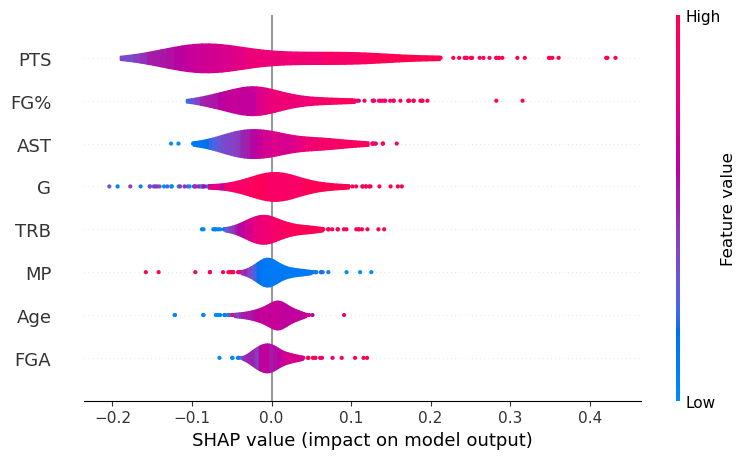

In [106]:
# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_train, plot_type="violin")

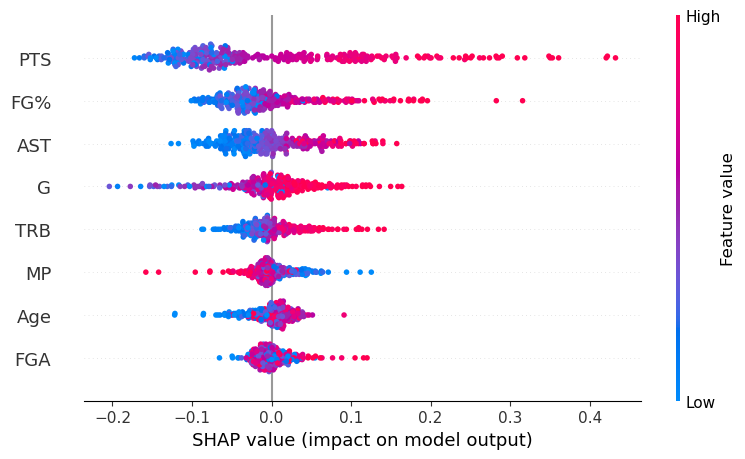

In [107]:
# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_train, plot_type="dot")